# Help dr. Vasilescu

Even if dr. Vasilescu has the equations the describe the dynamics of the robot, she cannot do anything directly with them. Help her design a controller for her robot, based on the dynamic process that she identified.

## Proposed problems

  Consider the AL5D_mdw robot with known matrices D, C, G given in the code. Implement an Independent Joint Control with PD controllers and Gravity compensation.
  
  1. Use step of amplitude 0.1 and interpret the plots.
  2. Adapt the natural frequencies and observe their influence on the movement and position of the robot.
  3. Add gravity compensation; interpret the plots.
  4. Use a sine wave of amplitude 0.5 as input joint trajectories
  5. Interpret the plots.

In [21]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from odeintw import *
import math as m
from math import pi
import roboticstoolbox as rtb
from roboticstoolbox import *
from lab_functions import *

# loading robot model
rob = rtb.models.DH.AL5D_mdw()

A = 0.1 # amplitude
A_sin = 0.5 # sine wave amplitude

# real system of al5d
def model(x,t,tau):  
    tau = tau.reshape(5,1) # reshaping for mathematical operations
    
    q  = x[:,0]  #first column of x, the states
    dq = x[:,1]  #second column of x, the states derivated

    G = rob.gravload(q).reshape(5,1)
    D = rob.inertia(q)
    C = rob.coriolis(q, dq)
    
    xdot1 = dq.reshape(5,1)
    xdot2 = np.matmul(np.linalg.inv(D), (tau - C.dot(dq).reshape(5,1) - G))
    
    xdot = np.concatenate((xdot1, xdot2), axis=1)

    return xdot

# time step
dt = 0.01

# final time
tf = 1

# nr of samples
n = int(np.round(tf/dt))

# Desired time samples for the solution. 
# np.arrange - returns evenly spaced values within a given interval.
t = np.arange(0, tf, dt)

# step reference, one column for each joint
sp = 0.1*np.heaviside([t,t,t,t,t], 0).T

# initialisation
q  = np.zeros((n,5))
dq = np.zeros((n,5))
tau = np.zeros((n,5))

# x0 is the initial condition of the state space
x0 = np.zeros((5,2))

G = rob.gravload(q[0,:]).reshape(5,1)
D = rob.inertia(q[0,:])
C = rob.coriolis(q[0,:], dq[0,:]+0.1)

# natural frequencies and damping coefficients for each joint
wn = [10,10,10,10,10]
zeta = [1,1,1,1,1]
K = 1

Kp = np.zeros((n,5))
Kd = np.zeros((n,5))

for i in range(5):
    Kp[i] = (D[i,i]*wn[i]**2)/K
    Kd[i] = (2*zeta[i]*wn[i]*D[i,i]-C[i,i])/K

# solve ODE for each step
for i in range(2,n):
    # progress bar for visualisation of elapsed time
    printProgressBar((i+1)/n, prefix="Progress:", suffix="complete", length=60)

    # span for next time step
    tspan = [t[i-1],t[i]]

    G = rob.gravload(q[i-1]).reshape(5,)
    # compute torques from the control law
    tau[i,:] =  K*(Kp[i]*(sp[i]-q[i]) + Kd[i]*(-dq[i])) + G[i]

    # solve for next step
    x = odeintw(model,x0,tspan,args=(tau[i,:],))

    # store solution for plotting
    q[i,:]  = x[1][:,0]
    dq[i,:] = x[1][:,1]

    # next initial condition 
    x0 = x[1]

IndexError: index 5 is out of bounds for axis 0 with size 5

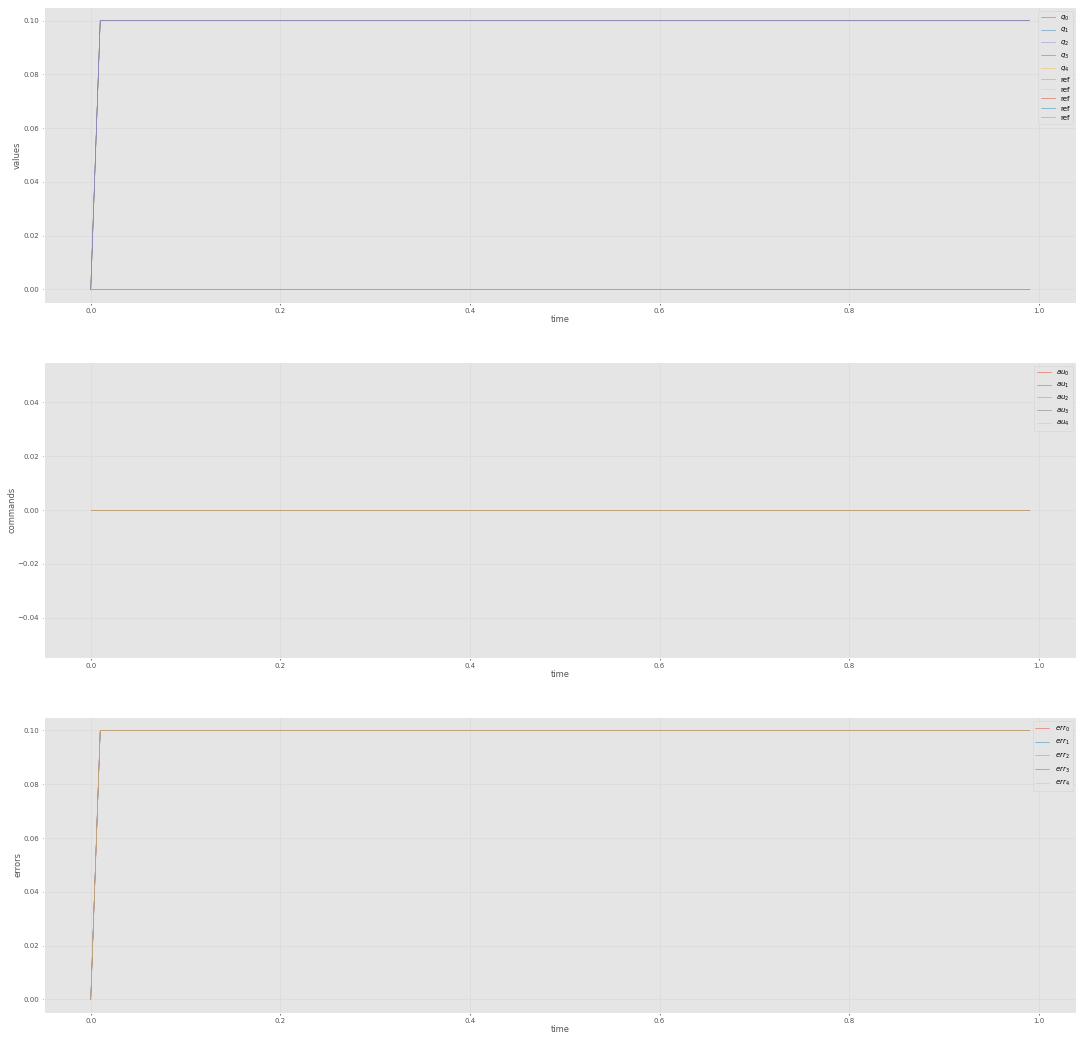

In [4]:
# plots 
fig = plt.figure()
fig.set_size_inches(18.5, 18.5)

plt.subplot(3, 1, 1)
for i in range(5):
    plt.plot(t, q[:,i], label='$q_'+str(i)+'$')
plt.plot(t, sp, label='ref')
plt.legend(loc='best')
plt.ylabel('values')
plt.xlabel('time')
plt.grid(True)

plt.subplot(3, 1, 2)
for i in range(5):
    plt.plot(t, tau[:,i], label='$\tau_'+str(i)+'$')
plt.legend(loc='best')
plt.ylabel('commands')
plt.xlabel('time')
plt.grid(True)

plt.subplot(3, 1, 3)
for i in range(5):
    plt.plot(t, sp[:,i]-q[:,i], label='$err_'+str(i)+'$')
plt.legend(loc='best')
plt.ylabel('errors')
plt.xlabel('time')
plt.grid(True)

plt.show()        

In [5]:
# animation
from lab_functions import *
import swift

# # 3D visualisation of the al5d_mdw
env = swift.Swift()
env.launch(realtime=True, browser='notebook')

al5d = rtb.models.URDF.AL5D_mdw()
al5d.q = q[0,:]

arrived = False
env.add(al5d)

for i in range(len(q)):
    al5d.q = np.radians(q[i,:])
    if i == 0:
        env.step(t[i])
    else:
        env.step(t[i]-t[i-1])


Could not open specified browser, using default instead

